## ANNEX 5 (1): LSTM (1)
In this Annex the method LSTM will be implemented for the time period from 2017-10-01 to 2018-03-22. Due to the window selection, however, the values predicted that will be obtained are 167 instead of 174 (number of days between the above dates). For that reason, predictions will start in 2017-10-07. In this case, a hidden layer consisting of 20 neurons is used. 

In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

# get market info for bitcoin from 28th April 2014 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# look at the first few rows
bitcoin_market_info = bitcoin_market_info[7:] #depending on which day you want for your last prediction.
#in this case it was 2018-03-22, as data is retrieved on 28th, we want only from row 6 onwards.
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
7,2018-03-22,8939.44,9100.71,8564.90,8728.47,5530390000,151366000000
8,2018-03-21,8937.48,9177.37,8846.33,8929.28,6043130000,151316000000
9,2018-03-20,8619.67,9051.02,8389.89,8913.47,6361790000,145922000000
10,2018-03-19,8344.12,8675.87,8182.40,8630.65,6729110000,141240000000
11,2018-03-18,7890.52,8245.51,7397.99,8223.68,6639190000,133547000000


In [2]:
# get market info for ethereum from the start of 2016 to the current day
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# look at the first few rows
eth_market_info = eth_market_info[7:]
eth_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
7,2018-03-22,562.10,577.57,523.09,539.70,1523460000,55273800000
8,2018-03-21,559.10,589.61,550.57,561.73,1781270000,54967300000
9,2018-03-20,556.72,567.09,521.20,557.17,1833680000,54722100000
10,2018-03-19,546.63,558.10,519.12,556.73,2046790000,53718600000
11,2018-03-18,551.64,551.64,460.09,538.64,2685500000,54200100000


In [3]:
#do the same for dash
dash_market_info = pd.read_html("https://coinmarketcap.com/currencies/dash/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
dash_market_info = dash_market_info.assign(Date=pd.to_datetime(dash_market_info['Date']))
#dash_market_info.loc[dash_market_info['Volume']=="-",'Volume']=0
# convert to int
dash_market_info['Volume'] = dash_market_info['Volume'].astype('int64')
# look at the first few rows
dash_market_info = dash_market_info[7:] 
dash_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
7,2018-03-22,434.44,438.40,398.59,411.36,96356400,3458220000
8,2018-03-21,429.15,450.64,424.79,434.51,115173000,3415280000
9,2018-03-20,412.49,442.05,399.17,428.88,109677000,3281830000
10,2018-03-19,392.32,409.32,368.52,409.32,113994000,3120600000
11,2018-03-18,388.19,394.15,342.51,394.15,117296000,3086950000


Some python packages have been loaded and then the table in https://coinmarketcap.com/currencies/bitcoin/historical-data/ is imported. After cleaning the data that table is obtained. By replacing 'bitcoin' with 'ethereum' the corresponding table for the 'ether' token is obtained. Below, both prices are plotted. 

In [4]:
# getting the Bitcoin and Eth logos
import sys
from PIL import Image
import io

if sys.version_info[0] < 3:
    import urllib2 as urllib
    bt_img = urllib.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
    eth_img = urllib.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")
else:
    import urllib
    bt_img = urllib.request.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
    eth_img = urllib.request.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")

image_file = io.BytesIO(bt_img.read())
bitcoin_im = Image.open(image_file)

image_file = io.BytesIO(eth_img.read())
eth_im = Image.open(image_file)
width_eth_im , height_eth_im  = eth_im.size
eth_im = eth_im.resize((int(eth_im.size[0]*0.1), int(eth_im.size[1]*0.1)), Image.ANTIALIAS)
bitcoin_im = bitcoin_im.resize((int(bitcoin_im.size[0]*0.1), int(bitcoin_im.size[1]*0.1)), Image.ANTIALIAS)

In [5]:
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]
dash_market_info.columns =[dash_market_info.columns[0]]+['dash_'+i for i in dash_market_info.columns[1:]]

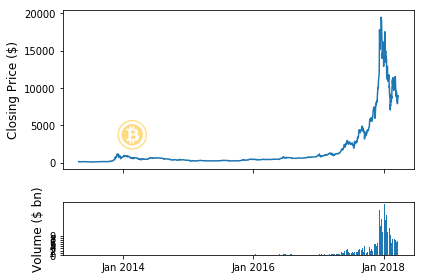

In [6]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in [2014, 2016, 2018] for j in [1]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in [2014, 2016, 2018] for j in [1]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in [2014, 2016, 2018] for j in [1]])
ax1.plot(bitcoin_market_info['Date'].astype(datetime.datetime),bitcoin_market_info['bt_Open'])
ax2.bar(bitcoin_market_info['Date'].astype(datetime.datetime).values, bitcoin_market_info['bt_Volume'].values)
fig.tight_layout()
fig.figimage(bitcoin_im, 100, 120, zorder=3,alpha=.5)
plt.show()

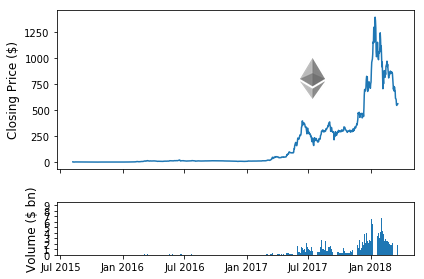

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
#ax1.set_yscale('log')
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(eth_market_info['Date'].astype(datetime.datetime),eth_market_info['eth_Open'])
ax2.bar(eth_market_info['Date'].astype(datetime.datetime).values, eth_market_info['eth_Volume'].values)
fig.tight_layout()
fig.figimage(eth_im, 300, 180, zorder=3, alpha=.6)
plt.show()

In [8]:
market_info = pd.merge(bitcoin_market_info,eth_market_info, on=['Date'])

market_info = pd.merge(market_info, dash_market_info, on=['Date'])

market_info = market_info[market_info['Date']>='2016-01-01'] 
for coins in ['bt_', 'eth_', 'dash_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,...,eth_Market Cap,dash_Open,dash_High,dash_Low,dash_Close,dash_Volume,dash_Market Cap,bt_day_diff,eth_day_diff,dash_day_diff
0,2018-03-22,8939.44,9100.71,8564.90,8728.47,5530390000,151366000000,562.10,577.57,523.09,...,55273800000,434.44,438.40,398.59,411.36,96356400,3458220000,-0.023600,-0.039851,-0.053126
1,2018-03-21,8937.48,9177.37,8846.33,8929.28,6043130000,151316000000,559.10,589.61,550.57,...,54967300000,429.15,450.64,424.79,434.51,115173000,3415280000,-0.000917,0.004704,0.012490
2,2018-03-20,8619.67,9051.02,8389.89,8913.47,6361790000,145922000000,556.72,567.09,521.20,...,54722100000,412.49,442.05,399.17,428.88,109677000,3281830000,0.034085,0.000808,0.039734
3,2018-03-19,8344.12,8675.87,8182.40,8630.65,6729110000,141240000000,546.63,558.10,519.12,...,53718600000,392.32,409.32,368.52,409.32,113994000,3120600000,0.034339,0.018477,0.043332
4,2018-03-18,7890.52,8245.51,7397.99,8223.68,6639190000,133547000000,551.64,551.64,460.09,...,54200100000,388.19,394.15,342.51,394.15,117296000,3086950000,0.042223,-0.023566,0.015353


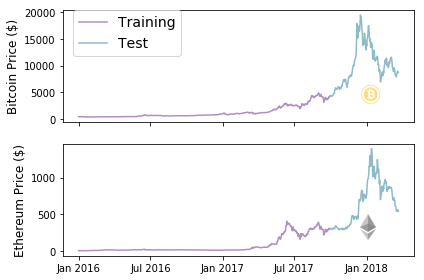

In [9]:
split_date = '2017-10-01' #as with the ARIMA + GARCH (1, 1), we start in 2017-10-01; 
#however, notice that due to the window selection, the first predicted value
#will correspond to 2017-10-07
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['bt_Close'], 
         color='#B08FC7', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['bt_Close'], 
         color='#8FBAC8', label='Test')
ax2.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['eth_Close'], 
         color='#B08FC7')
ax2.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['eth_Close'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
             350, 170, zorder=3,alpha=.5)
fig.figimage(eth_im.resize((int(eth_im.size[0]*0.65), int(eth_im.size[1]*0.65)), Image.ANTIALIAS), 
             360, 40, zorder=3,alpha=.5)
plt.show()

First, we may want to make sure the daily change in price follows a normal distribution. We'll plot the histogram of values. This is especially important for recurrent neural networks.

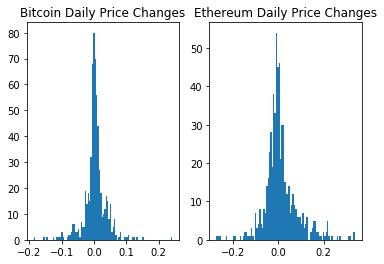

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(market_info[market_info['Date']< split_date]['bt_day_diff'].values, bins=100)
ax2.hist(market_info[market_info['Date']< split_date]['eth_day_diff'].values, bins=100)
ax1.set_title('Bitcoin Daily Price Changes')
ax2.set_title('Ethereum Daily Price Changes')
plt.show()

## Long Short Term Memory (LSTM)

For an explanation of how ANN, and especially LSTM work, see the references in the sub-section Long Short-Term Memory (LSTM). The Keras (2018) package is used. First, some transformations are carried out, in order to get variables 'close_off_high' and 'volatility' for each cryptocurrency.   

In [11]:
for coins in ['bt_', 'eth_', 'dash_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

In [12]:
model_data = market_info[['Date']+[coin+metric for coin in ['bt_', 'eth_', 'dash_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility,dash_Close,dash_Volume,dash_close_off_high,dash_volatility
811,2016-01-01,434.33,36278900,-0.560641,0.020292,0.948024,206062,-0.418477,0.025040,3.38,98317,6.666667e-02,0.090090
810,2016-01-02,433.44,30096600,0.250597,0.009641,0.937124,255504,0.965898,0.034913,3.28,62353,5.789474e-01,0.056213
809,2016-01-03,430.01,39633800,-0.173865,0.020827,0.971905,407632,-0.317885,0.060792,3.24,87155,-1.998401e-15,0.066869
808,2016-01-04,433.09,38477500,-0.474265,0.012649,0.954480,346245,-0.057657,0.047943,3.32,65748,-4.545455e-01,0.033846
807,2016-01-05,431.96,34522600,-0.013333,0.010391,0.950176,219833,0.697930,0.025236,3.33,71861,4.666667e-01,0.045181


A new data frame ('model_data') was created, removing columns Open, High and Low, and adding 'close_off_high', which represents how close the closing price is from the high price of that day. It is between 1 and -1 (1: close = high, -1: close = low). 'Volatility' is measured as the difference between high and low divided by open. 
This model uses previous data from bitcoin, ether and dash to predict next day's closing price of bitcoin and ether, separately. It has access to the previous 5 days (window = 5). After trying different windows, it was found that providing the model with too many previous data makes it remember long term relationships among the variables in the training phase that do not hold in the test phase. 
As widely varying inputs affect data negatively, the close price is normalized as in Aungiers (2017) to the first value of the window. 'Volume' column for each cryptocurrency is eliminated. After this normalization, most of the values for each window are between -1 and 1, which is desirable for deep learning models. 

In [13]:
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)
training_set = training_set.drop('bt_Volume', 1)
training_set = training_set.drop('eth_Volume', 1)
training_set = training_set.drop('dash_Volume', 1)
test_set = test_set.drop('bt_Volume', 1)
test_set = test_set.drop('eth_Volume', 1)
test_set = test_set.drop('dash_Volume', 1)
training_set = training_set.drop('dash_close_off_high', 1)
test_set = test_set.drop('dash_close_off_high', 1)


In [14]:
window_len = 5
norm_cols = [coin+metric for coin in ['bt_', 'eth_', 'dash_'] for metric in ['Close']]
print(norm_cols)

['bt_Close', 'eth_Close', 'dash_Close']


In [15]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1

In [16]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['eth_Close'][window_len:].values/test_set['eth_Close'][:-window_len].values)-1

print(type(LSTM_training_inputs))

<class 'list'>


In [17]:
LSTM_training_inputs[0]

,bt_Close,bt_close_off_high,bt_volatility,eth_Close,eth_close_off_high,eth_volatility,dash_Close,dash_volatility
811,0.000000,-0.560641,0.020292,0.000000,-0.418477,0.025040,0.000000,0.090090
810,-0.002049,0.250597,0.009641,-0.011498,0.965898,0.034913,-0.029586,0.056213
809,-0.009946,-0.173865,0.020827,0.025190,-0.317885,0.060792,-0.041420,0.066869
808,-0.002855,-0.474265,0.012649,0.006810,-0.057657,0.047943,-0.017751,0.033846
807,-0.005457,-0.013333,0.010391,0.002270,0.697930,0.025236,-0.014793,0.045181


There are hundreds of similar tables like the above (remember that the model takes 5 previous days and tries to predict the 6th closing price of bitcoin and ether, separately). The next step is to build the LSTM. As the close columns are normalized so that the first value in the window is 0, changes with respect to this point will be predicted. 

In [18]:
# easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [19]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM, LeakyReLU 
from keras.layers import Dropout
from keras.utils import plot_model

np.random.seed(202) 

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(0.25))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

Using TensorFlow backend.


This build_model function is then used for fitting the model into the data. The LSTM layer has been shaped to fit our inputs. For the rest of the specifications in the model, see the references provided in the sub-section 'Long Short-Term Memory (LSTM)'. 

In [20]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 5th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 5s - loss: 0.0942
Epoch 2/50
 - 4s - loss: 0.0703
Epoch 3/50
 - 4s - loss: 0.0696
Epoch 4/50
 - 4s - loss: 0.0666
Epoch 5/50
 - 4s - loss: 0.0620
Epoch 6/50
 - 4s - loss: 0.0617
Epoch 7/50
 - 4s - loss: 0.0606
Epoch 8/50
 - 4s - loss: 0.0601
Epoch 9/50
 - 4s - loss: 0.0582
Epoch 10/50
 - 4s - loss: 0.0578
Epoch 11/50
 - 4s - loss: 0.0574
Epoch 12/50
 - 4s - loss: 0.0580
Epoch 13/50
 - 4s - loss: 0.0581
Epoch 14/50
 - 4s - loss: 0.0568
Epoch 15/50
 - 4s - loss: 0.0568
Epoch 16/50
 - 4s - loss: 0.0551
Epoch 17/50
 - 4s - loss: 0.0544
Epoch 18/50
 - 4s - loss: 0.0540
Epoch 19/50
 - 4s - loss: 0.0553
Epoch 20/50
 - 4s - loss: 0.0564
Epoch 21/50
 - 4s - loss: 0.0563
Epoch 22/50
 - 4s - loss: 0.0559
Epoch 23/50
 - 4s - loss: 0.0546
Epoch 24/50
 - 4s - loss: 0.0555
Epoch 25/50
 - 4s - loss: 0.0557
Epoch 26/50
 - 4s - loss: 0.0552
Epoch 27/50
 - 4s - loss: 0.0550
Epoch 28/50
 - 4s - loss: 0.0548
Epoch 29/50
 - 4s - loss: 0.0545
Epoch 30/50
 - 4s - loss: 0.0544
Epoch 31/50
 - 4s -

In [21]:
import pydot_ng as pydot
print(pydot.find_graphviz())

{'fdp': '/anaconda3/bin/fdp', 'twopi': '/anaconda3/bin/twopi', 'sfdp': '/anaconda3/bin/sfdp', 'circo': '/anaconda3/bin/circo', 'neato': '/anaconda3/bin/neato', 'dot': '/anaconda3/bin/dot'}


In [22]:
plot_model(eth_model, to_file='LSTM_ethmodel_plot.png', show_shapes=True, show_layer_names=True)
#with this, the model structure is plotted into a new file. 

As it is noticeable, the error decreases throughout time, as expected. 

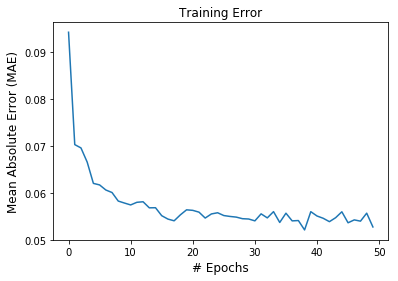

In [23]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

"We've just built an LSTM model to predict tomorrow's Ethereum closing price. Let's see how well it performs. We start by examining its performance on the training set (data before October 2017). That number below the code represents the model's mean absolute error (mae) on the training set after the 50th training iteration (or epoch). Instead of relative changes, we can view the model output as daily closing prices." (Sheehan, 2017)

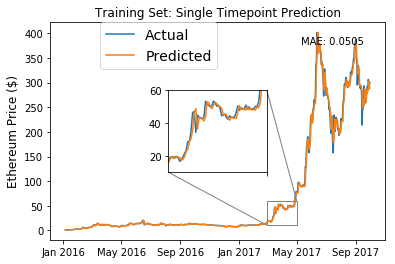

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['eth_Close'].values[window_len:])/(training_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 3.35, loc=10) # zoom-factor: 3.35, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 3, 1), datetime.date(2017, 5, 1)])
axins.set_ylim([10,60])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

As can be observed, the model is very accurate in the training phase, as expected. This, however, is not very surprising, as the model has access to its error every iteration. The prediction of interest is the one in the test phase, as it will show if the prediction error is so small due to good fit or due to overfitting. For avoiding this problem, a dropout of 0.25 was set in the model. 

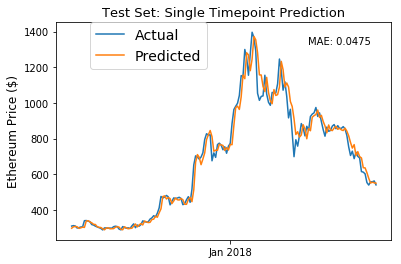

168
4.75345847702
the accuracy in percentage measured as 100 - MAPE for ether using LSTM is 95.24654


In [25]:
fig, ax1 = plt.subplots(1,1)
#ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
#ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.set_xticks([datetime.date(i,j,1) for i in range(2017,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2017,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['eth_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['eth_Close'].values[window_len:])/(test_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

print(len(eth_model.predict(LSTM_test_inputs)))


mape_eth = (100/len(eth_model.predict(LSTM_test_inputs)))*np.sum(np.abs(((np.transpose(eth_model.predict(LSTM_test_inputs)))+1)-\
            (test_set['eth_Close'].values[window_len:])/(test_set['eth_Close'].values[:-window_len])))

print(mape_eth) 

print('the accuracy in percentage measured as 100 - MAPE for ether using LSTM is %.5f'%(100-mape_eth))

#the accuracy in percentage measured as 100 - MAPE for ether using LSTM is 95.29775

As it is seen, the LSTM model performs well in the test period, with some weaknesses. First, the model tends to overestimate the future ether price, which can be due to the fact that during the training period ether's price rose incredibly, therefore it expects the trend to continue. Also, in spikes, where big changes take place, the model is not able to capture these behaviors. Now, the same methodology is applied to bitcoin's prices. 

In [26]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20, dropout = 0.25)
# train model on data
# note: btc_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs, 
                            (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 7s - loss: 0.0499
Epoch 2/50
 - 5s - loss: 0.0373
Epoch 3/50
 - 5s - loss: 0.0330
Epoch 4/50
 - 4s - loss: 0.0310
Epoch 5/50
 - 4s - loss: 0.0292
Epoch 6/50
 - 6s - loss: 0.0294
Epoch 7/50
 - 6s - loss: 0.0283
Epoch 8/50
 - 5s - loss: 0.0279
Epoch 9/50
 - 5s - loss: 0.0267
Epoch 10/50
 - 4s - loss: 0.0261
Epoch 11/50
 - 4s - loss: 0.0266
Epoch 12/50
 - 4s - loss: 0.0262
Epoch 13/50
 - 5s - loss: 0.0256
Epoch 14/50
 - 4s - loss: 0.0262
Epoch 15/50
 - 4s - loss: 0.0255
Epoch 16/50
 - 4s - loss: 0.0258
Epoch 17/50
 - 4s - loss: 0.0246
Epoch 18/50
 - 4s - loss: 0.0253
Epoch 19/50
 - 4s - loss: 0.0252
Epoch 20/50
 - 4s - loss: 0.0250
Epoch 21/50
 - 4s - loss: 0.0245
Epoch 22/50
 - 4s - loss: 0.0251
Epoch 23/50
 - 4s - loss: 0.0245
Epoch 24/50
 - 4s - loss: 0.0255
Epoch 25/50
 - 4s - loss: 0.0242
Epoch 26/50
 - 4s - loss: 0.0239
Epoch 27/50
 - 4s - loss: 0.0249
Epoch 28/50
 - 4s - loss: 0.0246
Epoch 29/50
 - 4s - loss: 0.0246
Epoch 30/50
 - 4s - loss: 0.0243
Epoch 31/50
 - 4s -

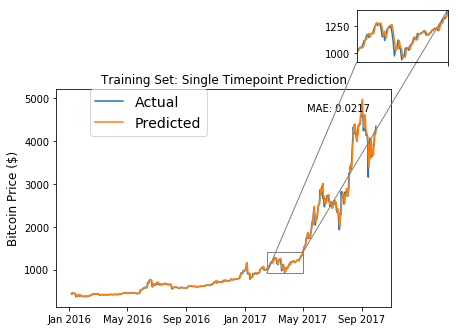

In [27]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_Close'].values[window_len:])/(training_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 2.52, loc=10, bbox_to_anchor=(400, 307)) # zoom-factor: 2.52, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 2, 15), datetime.date(2017, 5, 1)])
axins.set_ylim([920, 1400])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

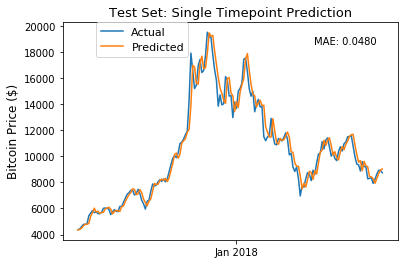

168
4.8027297515
the accuracy in percentage measured as 100 - MAPE for bitcoin using LSTM is 95.19727


In [28]:
fig, ax1 = plt.subplots(1,1)

ax1.set_xticks([datetime.date(i,j,1) for i in range(2017,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2017,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_Close'].values[window_len:])/(test_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 11})
plt.show()

print(len(bt_model.predict(LSTM_test_inputs)))

mape_bt = (100/len(bt_model.predict(LSTM_test_inputs)))*np.sum(np.abs(((np.transpose(bt_model.predict(LSTM_test_inputs)))+1)-\
            (test_set['bt_Close'].values[window_len:])/(test_set['bt_Close'].values[:-window_len])))

print(mape_bt) 

print('the accuracy in percentage measured as 100 - MAPE for bitcoin using LSTM is %.5f'%(100-mape_bt))

#

After getting the accuracy of LSTM for this time period, the next step is to check the trading strategy based in this algorithm, to calculate the sharp ratio. For that reason, the predicted prices are stored in the files below, in order to be able to work with them in R. 

In [29]:
eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-1][::1]+1)*\
                   test_set['eth_Close'].values[:-(window_len + 1)][::1].reshape(int(np.ceil((len(LSTM_test_inputs)-1)/float(1))),1))

np.savetxt("eth_pred_prices_lstm_1_def.csv", eth_pred_prices, delimiter="") #we save the predicted values in order to implement the rest of the backtesting for the trading strategy in R, as the language is more flexible. 

print(eth_pred_prices)

[[  296.53738853]
 [  304.66549371]
 [  306.28216115]
 [  304.64793331]
 [  295.52647624]
 [  298.45842013]
 [  302.51361959]
 [  300.87704337]
 [  336.67138608]
 [  338.80044281]
 [  331.74879306]
 [  326.91451198]
 [  318.36352643]
 [  317.36467263]
 [  305.24474037]
 [  301.4740749 ]
 [  300.43802184]
 [  293.59217714]
 [  287.57757056]
 [  297.47904253]
 [  298.64102738]
 [  293.27223557]
 [  293.73969998]
 [  294.12837914]
 [  302.08384758]
 [  305.12552995]
 [  302.73410032]
 [  290.43188028]
 [  287.79561855]
 [  304.51236567]
 [  298.50581074]
 [  293.22738141]
 [  296.37853993]
 [  295.87953745]
 [  308.00595636]
 [  320.44179418]
 [  303.88638878]
 [  314.71555506]
 [  322.49400638]
 [  314.83285642]
 [  336.96931958]
 [  331.94987072]
 [  328.19894673]
 [  329.44360958]
 [  345.11966677]
 [  347.36789417]
 [  364.55466473]
 [  358.0273463 ]
 [  383.05635701]
 [  405.05336628]
 [  474.23338306]
 [  477.94495411]
 [  460.69718906]
 [  468.89555432]
 [  462.79102011]
 [  434.84

In [30]:
bt_pred_prices = ((bt_model.predict(LSTM_test_inputs)[:-1][::1]+1)*\
                   test_set['bt_Close'].values[:-(window_len + 1)][::1].reshape(int(np.ceil((len(LSTM_test_inputs)-1)/float(1))),1))

np.savetxt("btc_pred_prices_lstm_1_def.csv", bt_pred_prices, delimiter="")

print(bt_pred_prices)
len(bt_pred_prices)

[[  4353.1458077 ]
 [  4393.27219514]
 [  4485.11609151]
 [  4662.66353363]
 [  4782.3879816 ]
 [  4778.56847114]
 [  4855.47456174]
 [  5411.19879654]
 [  5668.93033281]
 [  6019.15985291]
 [  5719.74330286]
 [  5788.01132626]
 [  5617.265059  ]
 [  5688.3020744 ]
 [  5705.38959125]
 [  5962.31520262]
 [  6021.89610192]
 [  6088.03273883]
 [  5952.31153031]
 [  5574.97999006]
 [  5751.91920402]
 [  5859.45665101]
 [  5806.82657306]
 [  5770.58512726]
 [  6135.40726342]
 [  6186.70958763]
 [  6519.64864243]
 [  6804.68932694]
 [  7044.61024488]
 [  7206.00631899]
 [  7498.2499413 ]
 [  7464.04635808]
 [  7064.07822186]
 [  7105.42418604]
 [  7445.71019557]
 [  7214.69884416]
 [  6715.6340502 ]
 [  6444.44630569]
 [  6199.51305183]
 [  6549.67882739]
 [  6732.26544964]
 [  7336.69947853]
 [  7914.16221685]
 [  7821.4911646 ]
 [  7859.23254353]
 [  8134.11994224]
 [  8247.37455338]
 [  8147.95336334]
 [  8302.1341501 ]
 [  8054.4040957 ]
 [  8329.05850182]
 [  8870.18658676]
 [  9421.795

167